<a href="https://colab.research.google.com/github/milioe/Moravec/blob/main/4_ComputerVision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Classification

* Classification with more data (our own models)
* Metrics (Precision // Recall // F1)
* Transfer Learning 
* **Weights and biases** vs TensorBoard
* Callbacks (Epochs, WB, checkpoints)
* Gradio // Hugging Faces

In [1]:
import zipfile

# Download zip file of 10_food_classes images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

--2022-07-23 18:33:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   188MB/s    in 2.6s    

2022-07-23 18:33:39 (188 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r") # r = read // w = write // a = append // b // wr
zip_ref.extractall()
zip_ref.close() # 

In [3]:
import os # through system

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [4]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [5]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0]) # target_folder/test/00001.jpg
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image shape: (512, 384, 3)


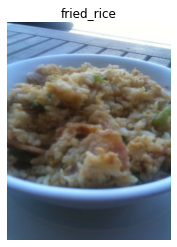

In [7]:
# View a random image from the training dataset
import random
img = view_random(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Baseline

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [10]:
# install wandb
!pip install wandb -q 

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 153 kB 71.4 MB/s 
     |████████████████████████████████| 181 kB 75.3 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 


In [11]:
import wandb
from wandb.keras import WandbCallback

In [12]:
# Login
# wandb.login()

In [13]:
# WB
# Project = repository
run = wandb.init(project="ComputerVision", name="model_0", config={"learning_rate":0.001, "epochs":5})


# set random
tf.random.set_seed(42)

# 1. Create model
model_0 = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation="softmax")
])

# 2. Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# 3. Fit model 
model_0.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
            validation_data=test_data, validation_steps=len(test_data),
            callbacks=[WandbCallback(monitor="val_loss")])

run.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/5
235/235 [==============================] - 61s 201ms/step - loss: 2.1312 - accuracy: 0.2257 - precision: 0.5128 - recall: 0.0080 - val_loss: 2.0409 - val_accuracy: 0.2580 - val_precision: 0.5294 - val_recall: 0.0108 - _timestamp: 1658601308.0000 - _runtime: 68.0000
Epoch 2/5
235/235 [==============================] - 47s 199ms/step - loss: 1.9141 - accuracy: 0.3241 - precision: 0.6197 - recall: 0.0521 - val_loss: 1.9994 - val_accuracy: 0.3000 - val_precision: 0.4783 - val_recall: 0.1060 - _timestamp: 1658601355.0000 - _runtime: 115.0000
Epoch 3/5
235/235 [==============================] - 46s 195ms/step - loss: 1.5795 - accuracy: 0.4544 - precision: 0.6985 - recall: 0.1977 - val_loss: 2.1044 - val_accuracy: 0.2820 - val_precision: 0.3857 - val_recall: 0.0884 - _timestamp: 1658601400.0000 - _runtime: 160.0000
Epoch 4/5
235/235 [==============================] - 46s 194ms/step - loss: 1.029

accuracy,▁▂▄▆█
epoch,▁▃▅▆█
loss,█▇▆▃▁
precision,▁▃▄▆█
recall,▁▁▃▅█
val_accuracy,▃█▆▄▁
val_loss,▁▁▁▄█
val_precision,█▇▄▃▁
val_recall,▁▅▄▇█
GFLOPS,0.07866
accuracy,0.85027
